In [1]:
import os
# print(os.getcwd())
os.chdir("..")
print(os.getcwd())

/home/b/b382119/AQUA/diagnostics/global_ocean


In [13]:
%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
import global_ocean_func as fn
import global_ocean_func2 as fn2
from aqua.util import load_yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Here we read one of the reference NextGEMS Cycle 3 simulations
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")

# And we extract the Potential Temperature and Practical Salinity fields, resampling in yearly means
# Yearly means are more adequate to identify  drifts as they are not contaminated by seasonal cycle signals
yearly_data = reader.retrieve()[["ocpt","so"]].resample(time="Y").mean()
yearly_data=yearly_data.rename({"nz1":"lev"})

In [4]:
config = load_yaml("config.yaml")
outputfig= config["outputfig"]


2023-07-10 09:17:35,514 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0
2023-07-10 09:17:35,550 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0
2023-07-10 09:17:35,587 - INFO -  data slicing for this region, latitude -90.0 to 90.0, longitude 0.0 to 360.0
2023-07-10 09:18:20,871 - INFO - ./figs/Hovmoller_TS_FullValue_global_ocean.png saved
2023-07-10 09:18:39,505 - INFO - ./figs/Hovmoller_TS_Anomaly_global_ocean.png saved
2023-07-10 09:18:57,267 - INFO - ./figs/Hovmoller_TS_StdAnomaly_global_ocean.png saved


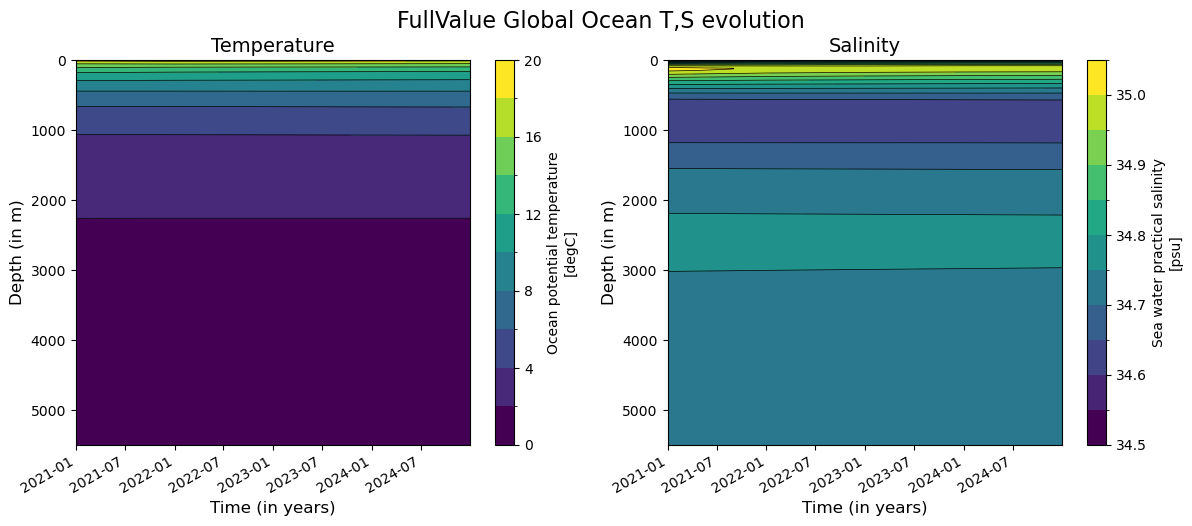

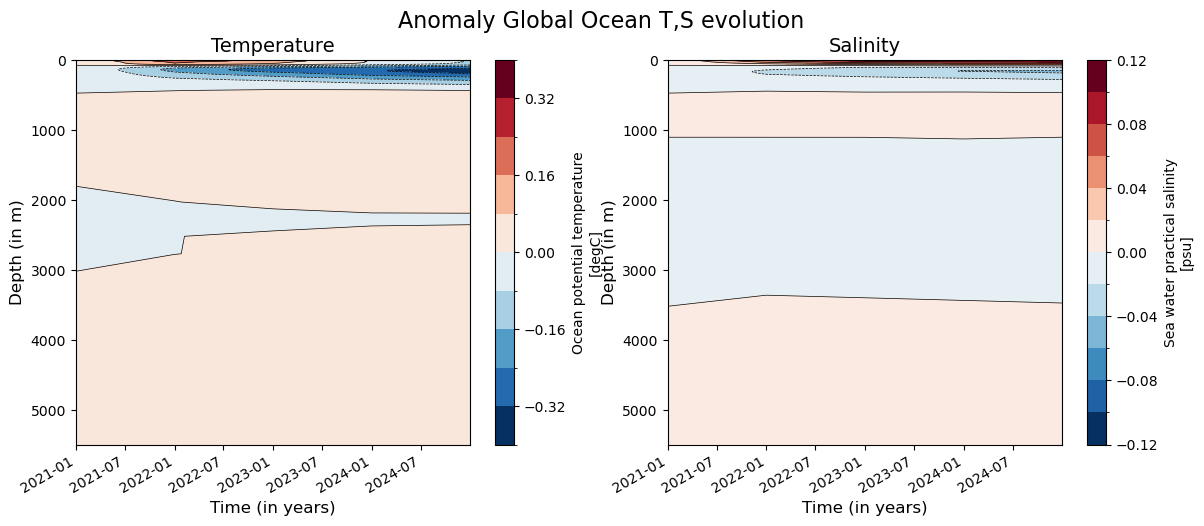

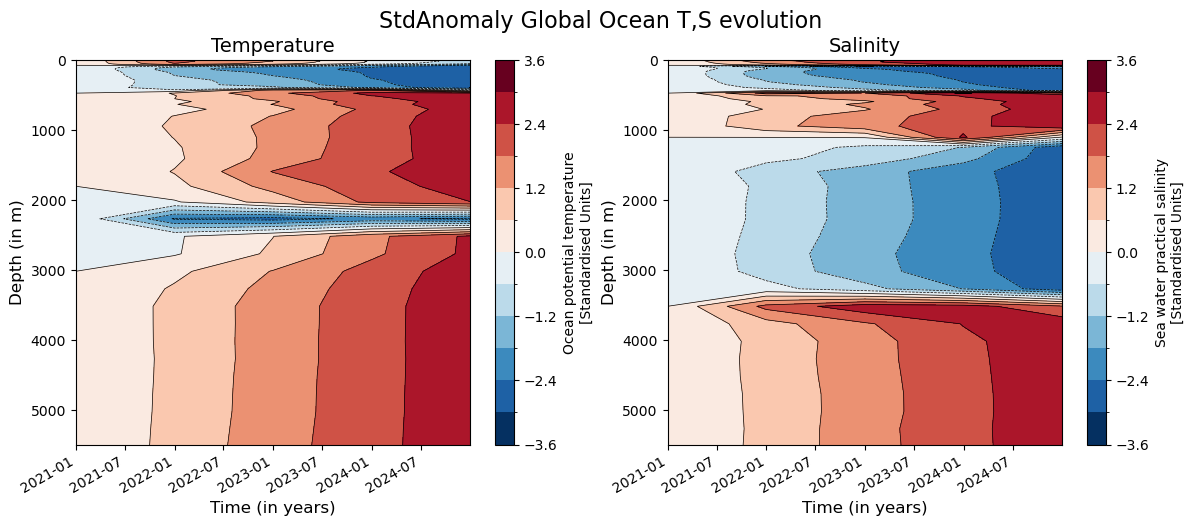

In [6]:
# We first focus on the GLOBAL OCEAN
 
# This function computes the weighted global averages as full values
global_mean_fv  = fn.reg_mean(yearly_data, region="Global Ocean")
# This one computes the weighted global averages as anomalies (wrt to the first value)
global_mean_anom_t0  = fn.anom_wrt_initial(yearly_data, region="Global Ocean")
# And this one the weighted global averages as standardised (wrt the depth level) anomalies (wrt to the first value)
global_mean_anom_t0_std = fn.std_anom_wrt_initial(yearly_data, region="Global Ocean")

# And we plot them in separate figures
fn.ocpt_so_hov_plot(global_mean_fv ,"Global Ocean",'FullValue', outputfig)
fn.ocpt_so_hov_plot(global_mean_anom_t0 ,"Global Ocean",'Anomaly', outputfig)
fn.ocpt_so_hov_plot(global_mean_anom_t0_std ,"Global Ocean",'StdAnomaly', outputfig)

# This function computes normalized anomalies as a function of depth and time
#  The anomalies are computed with respect to the first value (at t=0)
#global_mean_anom_t0_std = fn.std_anom_wrt_initial(yearly_data, region="Global Ocean")
## IDEALLY WE COULD ADD THE OPTION OF ALLOWING THE USER TO CHOOSE IF THE ANOMALY IS COMPUTED AGAINST THE
##  FIRST VALUE, THE MEAN OF THE WHOLE PERIOD, OR THE MEAN OF A SELECTED PERIOD
# This function produces the respective figure
#fn.ocpt_so_std_plot(global_mean_anom_t0_std ,"Global Ocean", outputfig)
# These functions produce an alternative version of non-normalized anomalies and plot them
#global_mean_anom_t0  = fn.anom_wrt_initial(yearly_data, region="Global Ocean")
#fn.ocpt_so_anom_plot(global_mean_anom_t0 ,"Global Ocean", outputfig)
## ADDING LOGARITHMIC SCALE OPTION TO COLORBAR IN ocpt_so_anom_plot
# Finally these functions complute the globally averaged full fields of T,S
# and plot them (It is less useful as the ocean is very stratified and drifts are less visible)
#global_mean  = fn.reg_mean(yearly_data, region="Global Ocean")
#fn.ocpt_so_full_plot(global_mean ,"Global Ocean", outputfig)




2023-07-07 13:41:43,274 - INFO - ./figs/TS_time_series_fullvalue_global_ocean.png saved


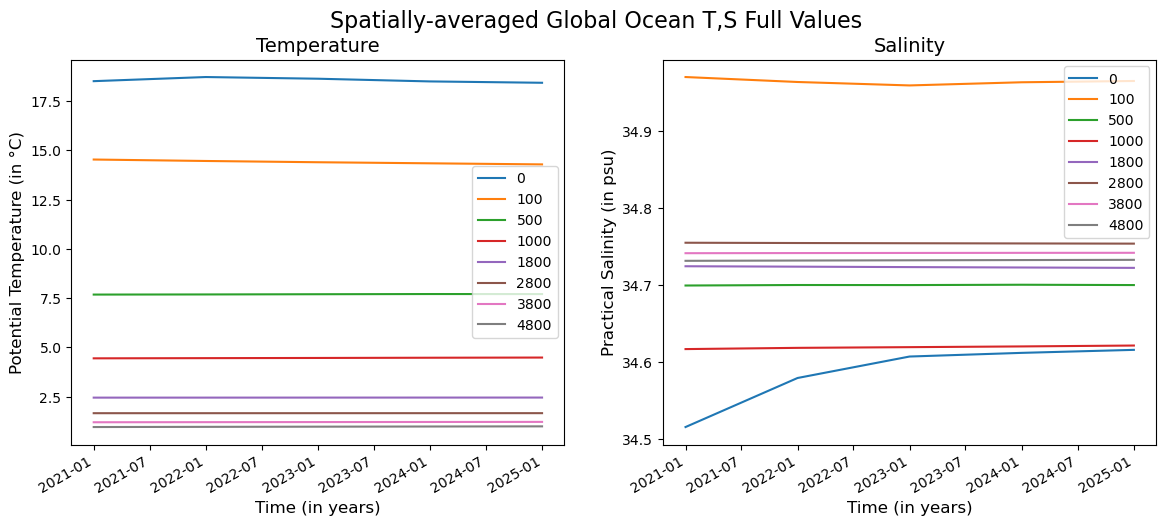

2023-07-07 13:42:48,455 - INFO - ./figs/TS_time_series_anomaly_global_ocean.png saved


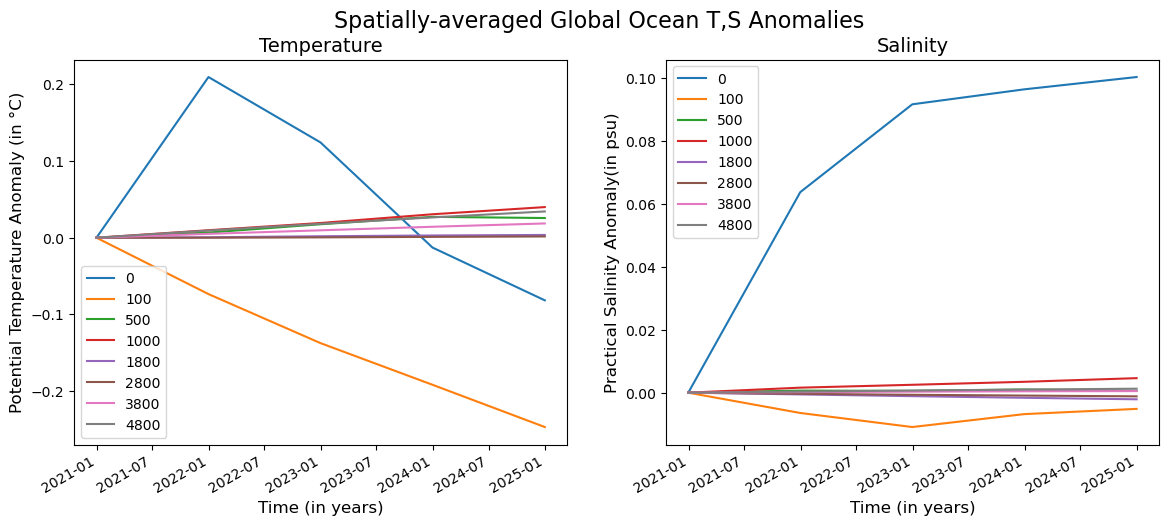

2023-07-07 13:43:56,279 - INFO - ./figs/TS_time_series_stdanomaly_global_ocean.png saved


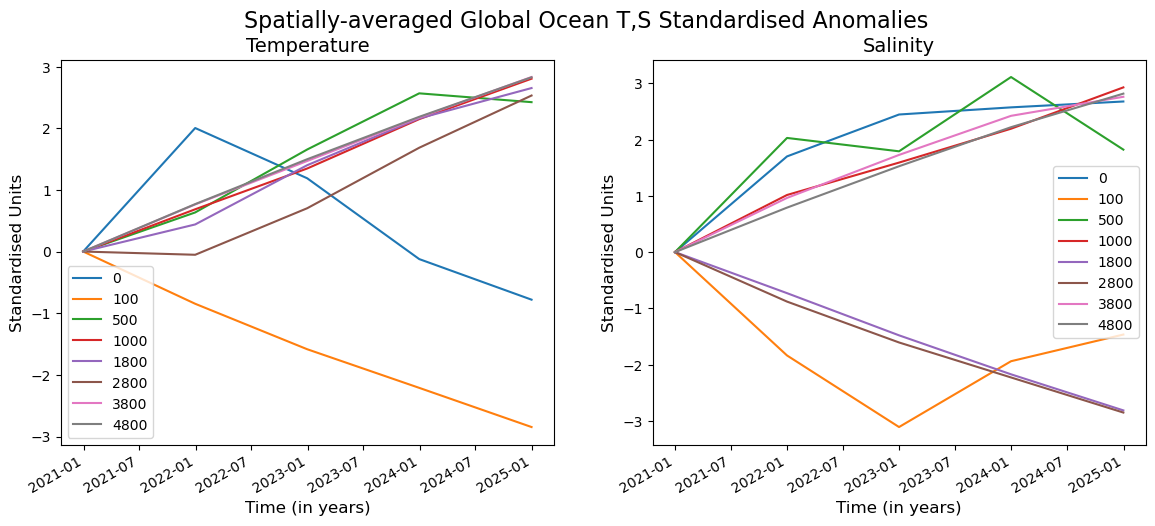

In [6]:
# This block is to produce plots with global mean timeseries at different depths

# First we do it for the full values
fn.time_series_custom(global_mean,'Global Ocean',type="FullValue",customise_level=False, levels=list, outputfig="./figs")
# Second for the anomalies with respect to the first value 
fn.time_series_custom(global_mean_anom_t0,'Global Ocean',type="Anomaly",customise_level=False, levels=list, outputfig="./figs")
# And third for the standardised anomalies
fn.time_series_custom(global_mean_anom_t0_std,'Global Ocean',type="StdAnomaly",customise_level=False, levels=list, outputfig="./figs")


In [7]:
# Here we compute the linear trends for both ocpt and so at all levels, longitudes and latitudes

ocpt_trends=fn3.lintrend_3D(yearly_data.ocpt)
so_trends=fn3.lintrend_3D(yearly_data.so)

#print(len(so_trends.lev))
#ocpt_1m_trends=fn.lintrend_2D(ocpt_1m)

#so_1m=yearly_data.so[:,1,:,:]
#so_1m_trends=fn.lintrend_2D(so_1m)
#so_1m_trends.plot()

#fn.trend_multilevel_plot

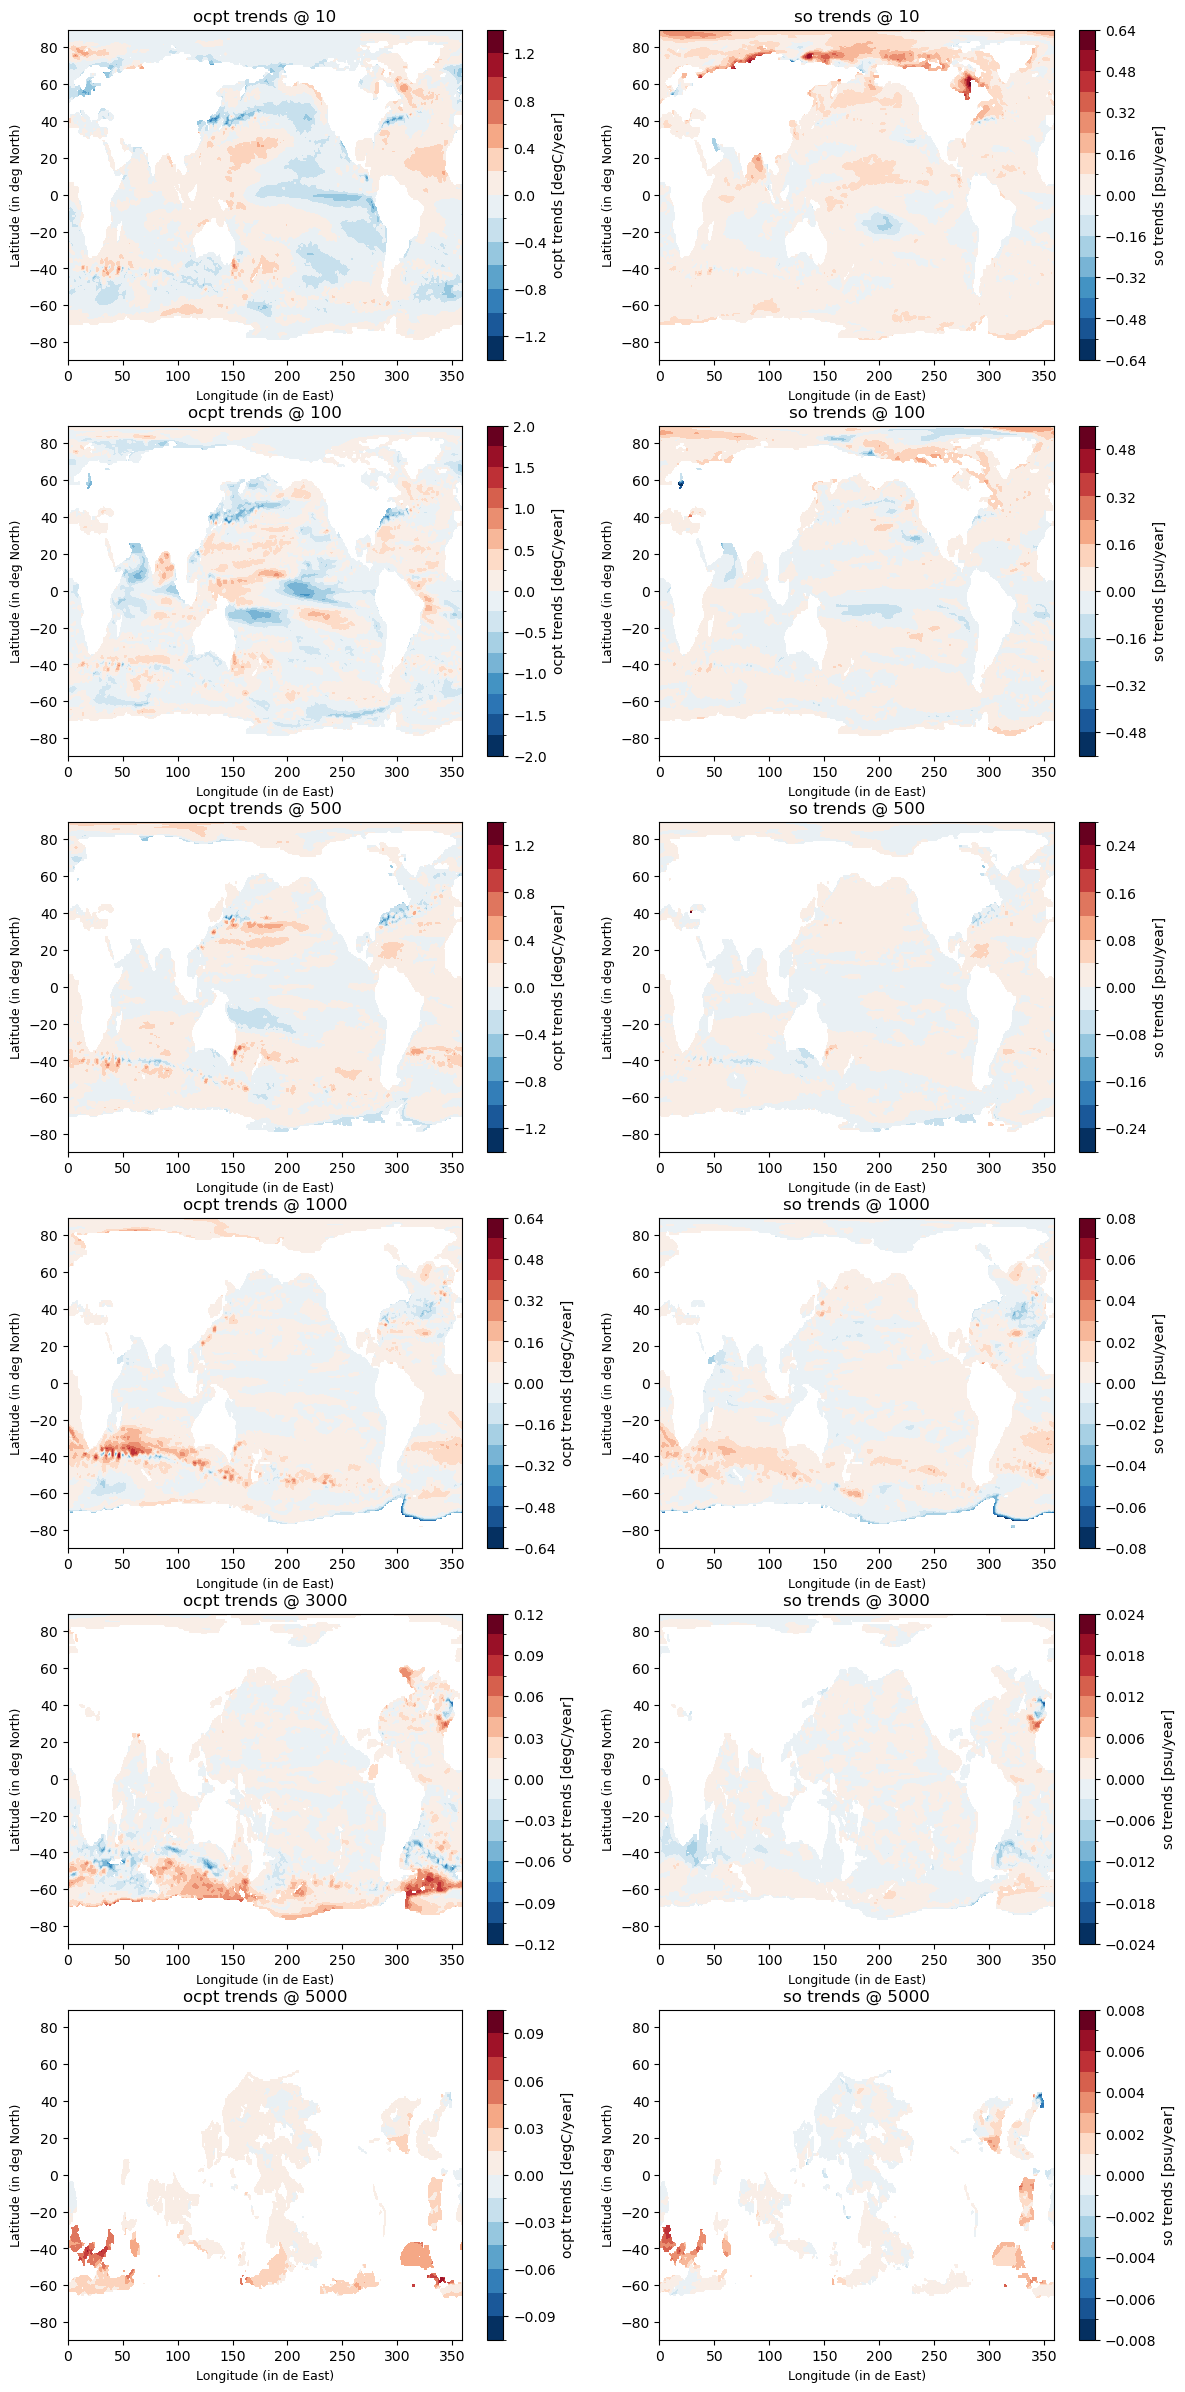

In [15]:
fn2.multilevel_t_s_trend_plot(ocpt_trends, so_trends, 'Global Ocean', customise_level=False, levels=None, outputfig="./figs")
# Some potential improvements to the plot: 
#  1. To have a common color scale for all subpanels in the same column
#  2. To use a logarithmic color scale so that the comparatively lower values at depth also show
#  3. To add a continental boundary line
#  4. To use a nicer-looking lat-lon projection (e.g. Robinson)

In [10]:
# Here we produce hovmoller figures for the Atlantic Ocean (as an example of the regional basins)
#   TO BE CONTINUED
atlantic_mean_anom = fn.std_anom_wrt_initial(yearly_data,region="Atlantic Ocean")
#pacific_mean_anom = fn.std_anom_wrt_initial(yearly_data,region="Pacific Ocean")
#indian_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Indian Ocean")
#arctic_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Arctic Ocean")
#southern_mean_anom = fn.std_anom_wrt_initial(yearly_data, region="Southern Ocean")

2023-07-07 09:49:51,489 - INFO -  data slicing for this region, latitude -35.0 to 65.0, longitude -80.0 to 30.0
2023-07-07 09:49:51,527 - INFO -  data slicing for this region, latitude -55.0 to 65.0, longitude 120.0 to 290.0
2023-07-07 09:49:51,560 - INFO -  data slicing for this region, latitude -30.0 to 30.0, longitude 100.0 to 300.0
2023-07-07 09:49:51,592 - INFO -  data slicing for this region, latitude 65.0 to 90.0, longitude 0.0 to 360.0
2023-07-07 09:49:51,624 - INFO -  data slicing for this region, latitude -80.0 to -55.0, longitude -180.0 to 180.0


In [1]:
#fn.ocpt_so_anom_plot(global_mean_anom,"Global Ocean", outputfig)
#fn.ocpt_so_anom_plot(atlantic_mean_anom,"Atlantic Ocean", outputfig)
#fn.ocpt_so_anom_plot(pacific_mean_anom,"Pacific Ocean", outputfig)
#fn.ocpt_so_anom_plot(indian_mean_anom,"Indian Ocean", outputfig)
#fn.ocpt_so_anom_plot(arctic_mean_anom,"Arctic Ocean", outputfig)
#fn.ocpt_so_anom_plot(southern_mean_anom,"Southern Ocean", outputfig)

type: Custom levels are selected, but levels are not provided.

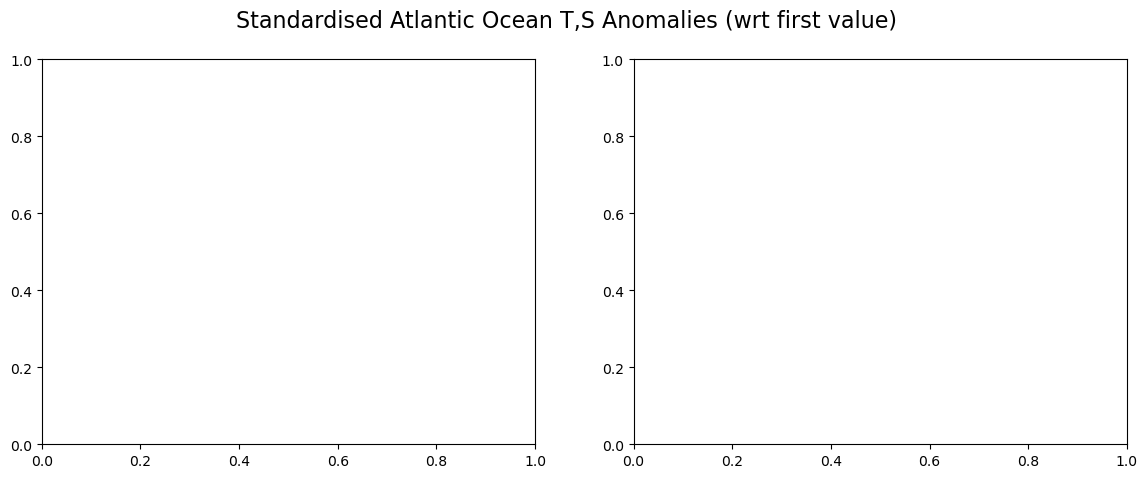

In [11]:
fn.time_series(global_mean_anom,'Global Ocean',customise_level=False, levels=list, outputfig)
fn.time_series(atlantic_mean_anom,'Atlantic Ocean', outputfig)
fn.time_series(pacific_mean_anom,'Pacific Ocean', outputfig)
fn.time_series(indian_mean_anom,'Indian Ocean', outputfig)
fn.time_series(arctic_mean_anom,'Arctic Ocean', outputfig)
fn.time_series(southern_mean_anom,'Southern Ocean', outputfig)